## Feature set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 96))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 24, 4, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 24, 4, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 24, 4, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 24, 4, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 24, 4, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 24, 4, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 24, 4, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 24, 4, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 24, 4, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 24, 4, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 24, 4)
Y_data 1 = (873, 1)
X_data 2 = (888, 24, 4)
Y_data 2 = (888, 1)
X_data 3 = (925, 24, 4)
Y_data 3 = (925, 1)
X_data 4 = (990, 24, 4)
Y_data 4 = (990, 1)
X_data 5 = (936, 24, 4)
Y_data 5 = (936, 1)
X_data 6 = (823, 24, 4)
Y_data 6 = (823, 1)
X_data 7 = (838, 24, 4)
Y_data 7 = (838, 1)
X_data 8 = (806, 24, 4)
Y_data 8 = (806, 1)
X_data 9 = (816, 24, 4)
Y_data 9 = (816, 1)
X_data 10 = (837, 24, 4)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [10]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [11]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [12]:
def Model_run_nn_es_NO_EARLY_STOPPING(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [13]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(val_loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table function

In [14]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [15]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [16]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [18]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [19]:
model=Sequential()
model.add(Flatten(input_shape=[24, 4]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [20]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array_1=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array_1, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4) (7859, 1) (873, 24, 4) (873, 1)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.3178241550922394
Time to train Fold 1 : 38.9714 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4) (7844, 1) (888, 24, 4) (888, 1)
Accuracy of Fold 2 is 0.193995401263237
Time to train Fold 2 : 42.1034 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4) (7807, 1) (925, 24, 4) (925, 1)
Accuracy of Fold 3 is 0.17883437871932983
Time to train Fold 3 : 41.9377 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4) (7742, 1) (990, 24, 4) (990, 1)
Accuracy of Fold 4 is 0.17516404390335083
Time to train Fold 4 : 41.4872 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4) (7796, 1) (936, 24, 4) (936, 1)
Accuracy of Fold 5 is 0.18862493336200714
Time to train Fold 5 : 40.3565 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4) (7909, 1) (823, 24, 4) (823, 1)
Accuracy of Fold 6 is 0.1988544911146164
Time to train Fold 6 : 42.355 seconds.

Fold #7
- - - - - - - - - - - - - - -

In [21]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.12479418569131168, 0.27282226460356745, 0.19358533791523483, 0.19358533791523483
2, 0.09072810498470645, 0.20641301361004089, 0.15653153153153154, 0.15653153153153154
3, 0.1339386770067712, 0.1801564634178543, 0.19783783783783784, 0.19783783783783784
4, 0.1811666139826822, 0.2437742851751063, 0.23434343434343435, 0.23434343434343435
5, 0.10574794426790352, 0.30706786871170433, 0.16987179487179488, 0.16987179487179488
6, 0.07068148613846109, 0.21617783082735378, 0.1166464155528554, 0.1166464155528554
7, 0.024364304677936245, 0.17577656798646518, 0.0954653937947494, 0.0954653937947494
8, 0.16462525153794016, 0.24616421910655473, 0.21215880893300249, 0.21215880893300249
9, 0.1849012517475228, 0.38294580878895984, 0.23161764705882354, 0.23161764705882354
10, 0.06570550301211918, 0.25701371022714775, 0.13859020310633213, 0.13859020310633213


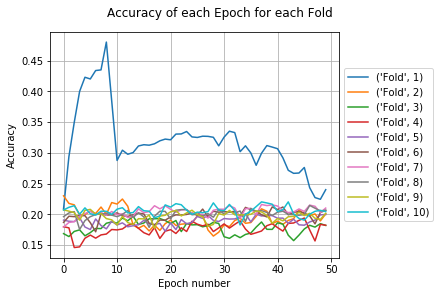

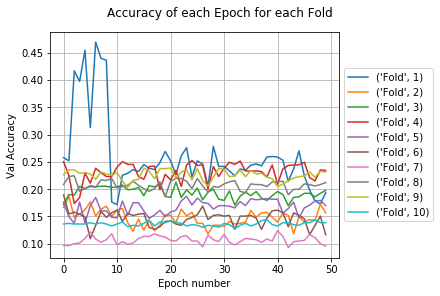

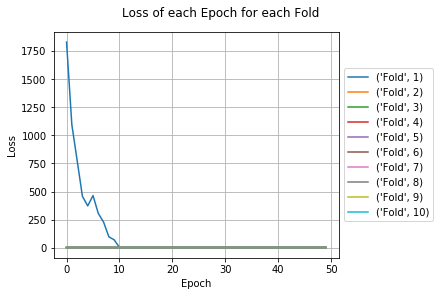

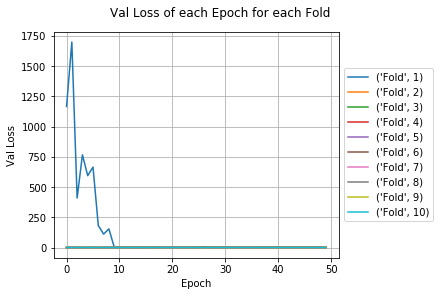

In [22]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array_1)

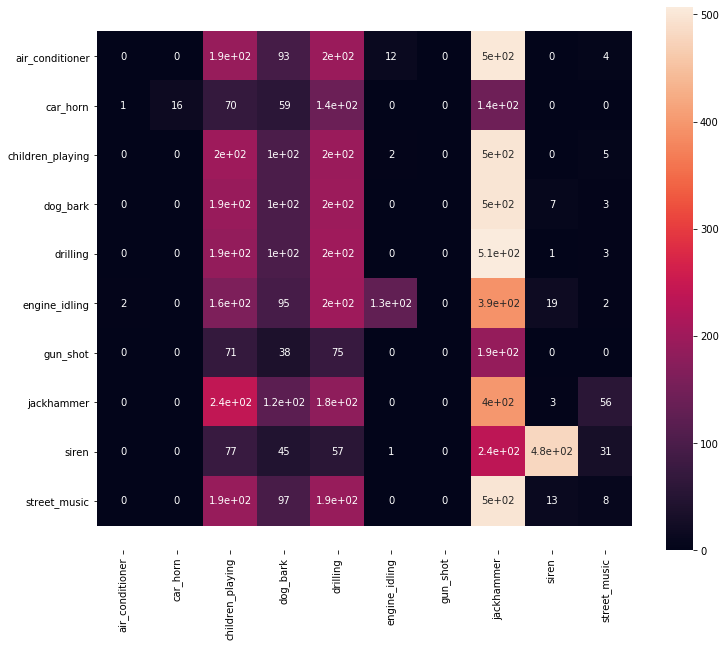

In [23]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [24]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.317824     38.9714
1    2  0.193995     42.1034
2    3  0.178834     41.9377
3    4  0.175164     41.4872
4    5  0.188625     40.3565
5    6  0.198854     42.3550
6    7  0.204163     40.5091
7    8  0.200368     37.0116
8    9  0.196867     35.8559
9   10  0.206115     36.1331

    Average Accuracy  Total Time
0          0.206081    396.7209


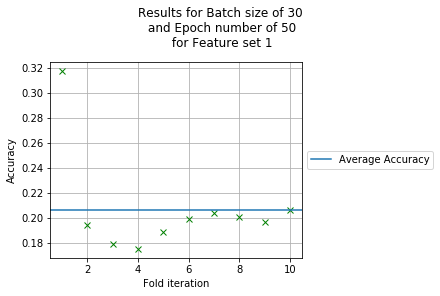

In [25]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [26]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 1.9179 - accuracy: 0.34 - ETA: 0s - loss: 1.9834 - accuracy: 0.22 - ETA: 0s - loss: 1.9662 - accuracy: 0.23 - ETA: 0s - loss: 1.9907 - accuracy: 0.21 - ETA: 0s - loss: 1.9789 - accuracy: 0.22 - ETA: 0s - loss: 1.9775 - accuracy: 0.22 - ETA: 0s - loss: 1.9789 - accuracy: 0.22 - ETA: 0s - loss: 1.9727 - accuracy: 0.22 - ETA: 0s - loss: 1.9701 - accuracy: 0.22 - ETA: 0s - loss: 1.9769 - accuracy: 0.22 - ETA: 0s - loss: 1.9794 - accuracy: 0.22 - ETA: 0s - loss: 1.9785 - accuracy: 0.23 - ETA: 0s - loss: 1.9802 - accuracy: 0.23 - ETA: 0s - loss: 1.9775 - accuracy: 0.23 - ETA: 0s - loss: 1.9767 - accuracy: 0.23 - ETA: 0s - loss: 1.9792 - accuracy: 0.23 - ETA: 0s - loss: 1.9840 - accuracy: 0.22 - ETA: 0s - loss: 1.9875 - accuracy: 0.22 - 1s 124us/step - loss: 1.9891 - accuracy: 0.2227 - val_loss: 2.6656 - val_accuracy: 0.1481
Epoch 2/30
7895/7895 [=============================

## Model 2

In [27]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(24,4,1)))
#model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.8329176902770996
Time to train Fold 1 : 52.0059 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.9503945708274841
Time to train Fold 2 : 19.0879 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.950194239616394
Time to train Fold 3 : 17.8982 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.9532635807991028
Time to train Fold 4 : 17.6146 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.9543932676315308
Time to train Fold 5 : 23.9714 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823

In [29]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.611200841631313, 0.6350983895618044, 0.6242840778923253, 0.6242840778923253
1, 0.9135018956981714, 0.9165942671394041, 0.9132882882882883, 0.9132882882882883
2, 0.8477944237671718, 0.8621560965122751, 0.8497297297297297, 0.8497297297297297
3, 0.9186949206352004, 0.9228728841049514, 0.9191919191919192, 0.9191919191919192
4, 0.9141060278283264, 0.9161224038367, 0.9145299145299145, 0.9145299145299145
5, 0.9330115841470964, 0.93620312356614, 0.9331713244228432, 0.9331713244228432
6, 0.9266646989911581, 0.9332397003512123, 0.9260143198090692, 0.9260143198090692
7, 0.9090845174454315, 0.9116440126414459, 0.9094292803970223, 0.9094292803970223
8, 0.9440388739366581, 0.9499503861587033, 0.9436274509803921, 0.9436274509803921
9, 0.9343581752003228, 0.9387011832368712, 0.9342891278375149, 0.9342891278375149


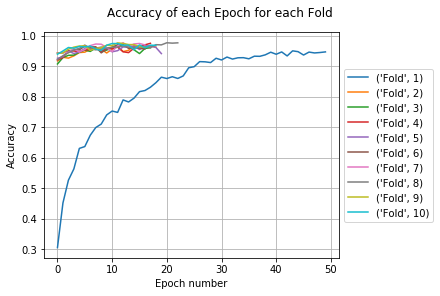

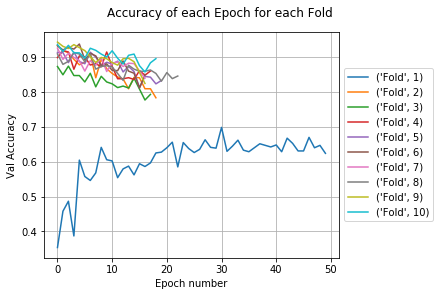

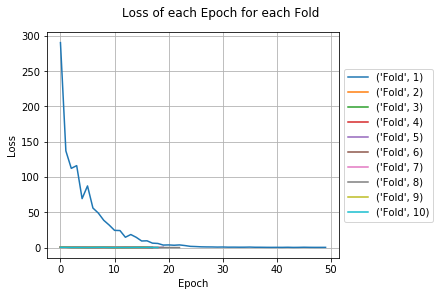

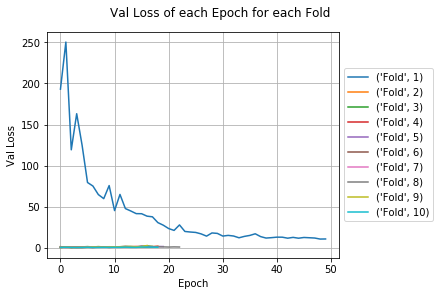

In [30]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

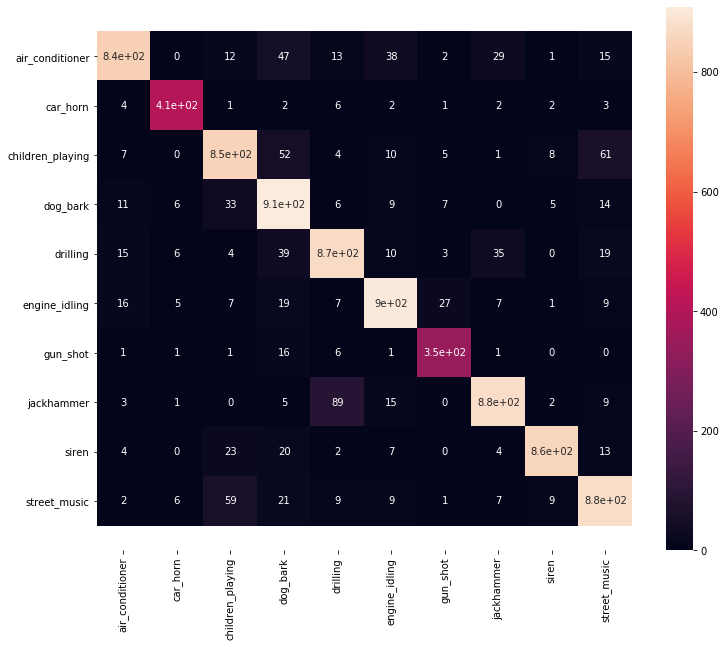

In [31]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [32]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.832918     52.0059
1    2  0.950395     19.0879
2    3  0.950194     17.8982
3    4  0.953264     17.6146
4    5  0.954393     23.9714
5    6  0.957591     24.5058
6    7  0.961400     24.0916
7    8  0.960186     32.7572
8    9  0.962860     24.0335
9   10  0.962815     27.3398

    Average Accuracy  Total Time
0          0.944602    263.3059


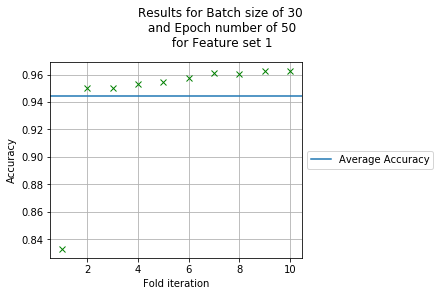

In [33]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [34]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 0.2769 - accuracy: 0.93 - ETA: 1s - loss: 0.1436 - accuracy: 0.96 - ETA: 1s - loss: 0.1184 - accuracy: 0.96 - ETA: 7s - loss: 0.1134 - accuracy: 0.96 - ETA: 5s - loss: 0.1044 - accuracy: 0.97 - ETA: 4s - loss: 0.1023 - accuracy: 0.96 - ETA: 3s - loss: 0.1286 - accuracy: 0.96 - ETA: 3s - loss: 0.1370 - accuracy: 0.96 - ETA: 2s - loss: 0.1490 - accuracy: 0.96 - ETA: 2s - loss: 0.1612 - accuracy: 0.96 - ETA: 2s - loss: 0.2018 - accuracy: 0.96 - ETA: 2s - loss: 0.2169 - accuracy: 0.96 - ETA: 2s - loss: 0.2247 - accuracy: 0.95 - ETA: 1s - loss: 0.2186 - accuracy: 0.95 - ETA: 1s - loss: 0.2158 - accuracy: 0.96 - ETA: 1s - loss: 0.2092 - accuracy: 0.96 - ETA: 1s - loss: 0.2306 - accuracy: 0.96 - ETA: 1s - loss: 0.2267 - accuracy: 0.96 - ETA: 1s - loss: 0.2222 - accuracy: 0.96 - ETA: 1s - loss: 0.2181 - accuracy: 0.96 - ETA: 1s - loss: 0.2215 - accuracy: 0.96 - ETA: 1s - loss:

## Model 3

In [66]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [67]:
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Accuracy_array_3=[]
Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.21269118785858154
Time to train Fold 1 : 102.6597 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.3718474209308624
Time to train Fold 2 : 54.4403 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.43962597846984863
Time to train Fold 3 : 41.1 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.5101930499076843
Time to train Fold 4 : 56.8443 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.6123027801513672
Time to train Fold 5 : 66.2139 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 24, 4, 1) (823, 10)
Accuracy of Fold 6 is 0.7136978507041931
Time to train Fold 6 : 35.075 seconds.


In [68]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.239441887116502, 0.21351101414970722, 0.33676975945017185, 0.33676975945017185
2, 0.4133814475349399, 0.40627494819428184, 0.4650900900900901, 0.4650900900900901
3, 0.4429999945694615, 0.44779599332599, 0.4875675675675676, 0.4875675675675676
4, 0.5224887820159964, 0.5318986896715924, 0.5515151515151515, 0.5515151515151515
5, 0.6705550751615637, 0.715462827521574, 0.6709401709401709, 0.6709401709401709
6, 0.6550916207562153, 0.6695503239099394, 0.6561360874848117, 0.6561360874848117
7, 0.7757515879619463, 0.7950711183096236, 0.7756563245823389, 0.7756563245823389
8, 0.7851282434258879, 0.7918616293195955, 0.7878411910669976, 0.7878411910669976
9, 0.7817941064629815, 0.8107965945940054, 0.7830882352941176, 0.7830882352941176
10, 0.8355800339582794, 0.8462799263215567, 0.8375149342891278, 0.8375149342891278


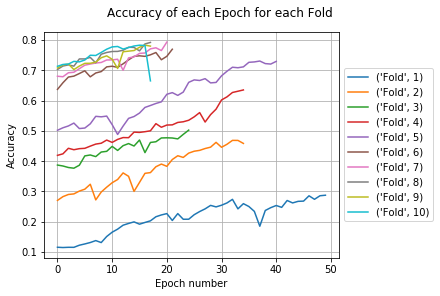

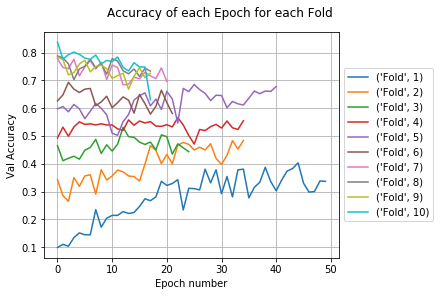

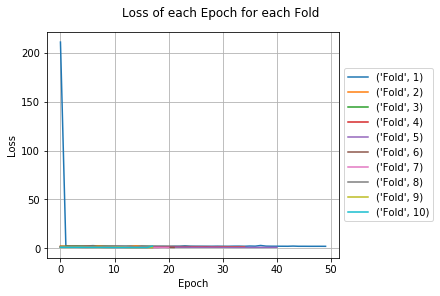

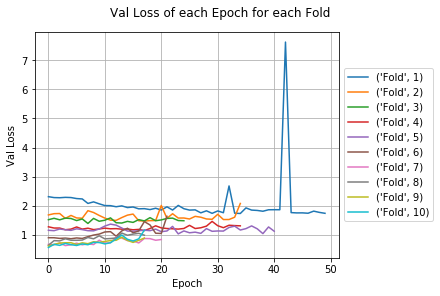

In [69]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

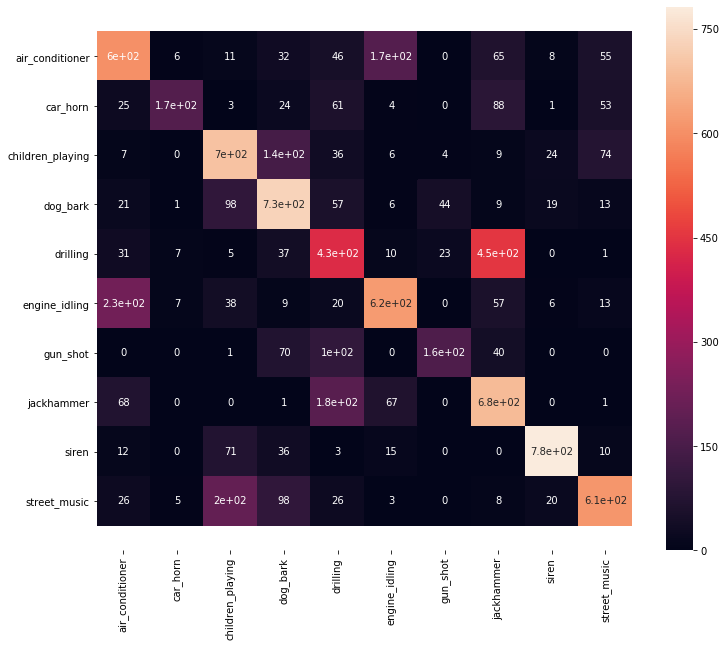

In [70]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [71]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.212691    102.6597
1    2  0.371847     54.4403
2    3  0.439626     41.1000
3    4  0.510193     56.8443
4    5  0.612303     66.2139
5    6  0.713698     35.0750
6    7  0.730820     34.0430
7    8  0.749495     29.5267
8    9  0.738806     30.0215
9   10  0.749222     29.4631

    Average Accuracy  Total Time
0           0.58287    479.3875


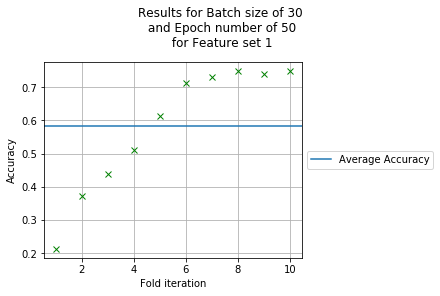

In [72]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [73]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 0.6308 - accuracy: 0.78 - ETA: 1s - loss: 0.6976 - accuracy: 0.76 - ETA: 1s - loss: 0.7366 - accuracy: 0.75 - ETA: 1s - loss: 0.7528 - accuracy: 0.73 - ETA: 1s - loss: 0.7899 - accuracy: 0.72 - ETA: 1s - loss: 0.7847 - accuracy: 0.72 - ETA: 1s - loss: 0.7895 - accuracy: 0.72 - ETA: 1s - loss: 0.8001 - accuracy: 0.72 - ETA: 1s - loss: 0.8225 - accuracy: 0.72 - ETA: 1s - loss: 0.8142 - accuracy: 0.72 - ETA: 0s - loss: 0.8118 - accuracy: 0.72 - ETA: 0s - loss: 0.8074 - accuracy: 0.72 - ETA: 0s - loss: 0.8023 - accuracy: 0.72 - ETA: 0s - loss: 0.7976 - accuracy: 0.72 - ETA: 0s - loss: 0.7977 - accuracy: 0.72 - ETA: 0s - loss: 0.7942 - accuracy: 0.72 - ETA: 0s - loss: 0.7914 - accuracy: 0.72 - ETA: 0s - loss: 0.7892 - accuracy: 0.72 - ETA: 0s - loss: 0.7930 - accuracy: 0.72 - ETA: 0s - loss: 0.7938 - accuracy: 0.72 - ETA: 0s - loss: 0.7939 - accuracy: 0.72 - ETA: 0s - loss:

## Model 4

In [43]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [44]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es_NO_EARLY_STOPPING(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.7184985280036926
Time to train Fold 1 : 138.6963 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.9010403156280518
Time to train Fold 2 : 132.2167 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.9307594895362854
Time to train Fold 3 : 126.7316 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.9439576864242554
Time to train Fold 4 : 129.0454 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.9540277719497681
Time to train Fold 5 : 131.9006 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10

In [45]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5650324287747599, 0.5712379368385446, 0.5750286368843069, 0.5750286368843069
2, 0.6597834547573203, 0.71696629036709, 0.6666666666666666, 0.6666666666666666
3, 0.764525606567168, 0.7823872818062646, 0.7686486486486487, 0.7686486486486487
4, 0.8346046975213967, 0.8419577856595621, 0.8353535353535354, 0.8353535353535354
5, 0.8970522898092744, 0.8993093250275501, 0.8974358974358975, 0.8974358974358975
6, 0.7174455192812976, 0.7805673790702834, 0.7314702308626975, 0.7314702308626975
7, 0.8661302095190475, 0.8779863353865889, 0.8675417661097852, 0.8675417661097852
8, 0.8607455926248665, 0.8718223562877773, 0.8610421836228288, 0.8610421836228288
9, 0.8697742812716326, 0.8789542641888204, 0.8688725490196079, 0.8688725490196079
10, 0.9192959486974036, 0.9280984574839289, 0.918757467144564, 0.918757467144564


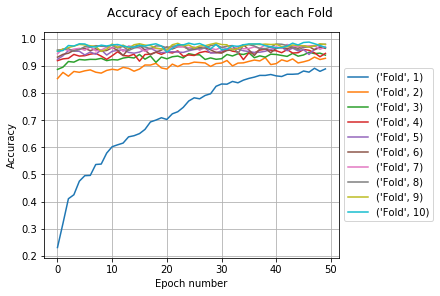

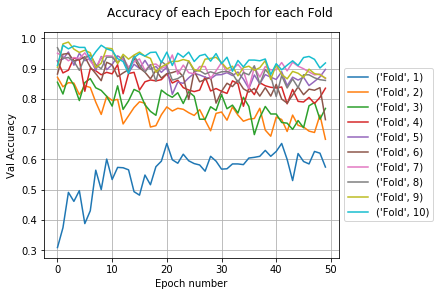

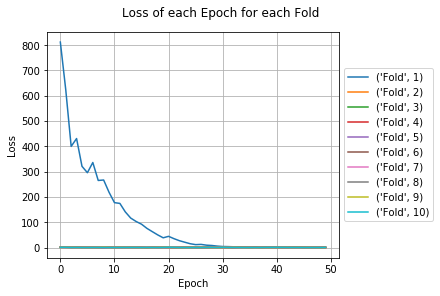

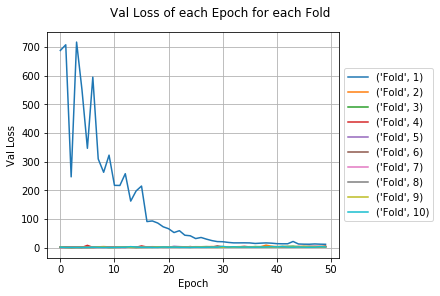

In [46]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

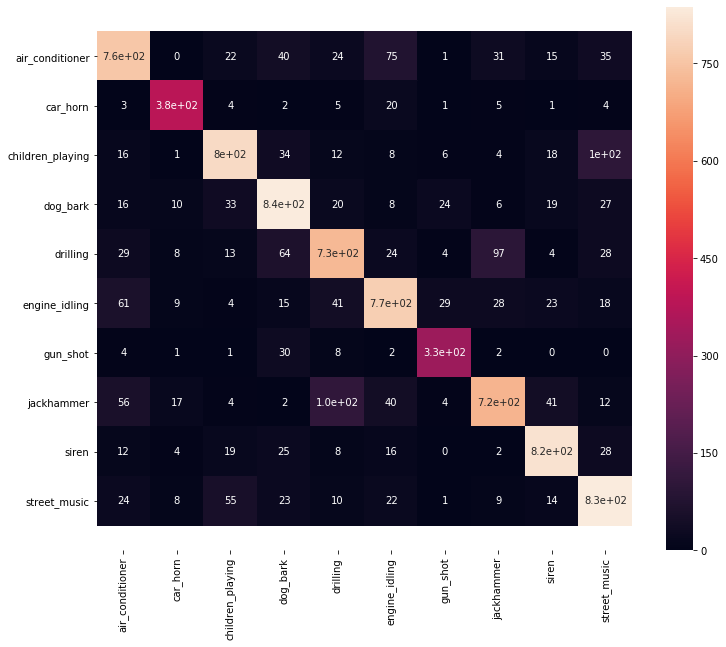

In [47]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [48]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.718499    138.6963
1    2  0.901040    132.2167
2    3  0.930759    126.7316
3    4  0.943958    129.0454
4    5  0.954028    131.9006
5    6  0.959454    131.4436
6    7  0.964996    136.3815
7    8  0.968504    130.6152
8    9  0.972362    132.5880
9   10  0.973224    130.7388

    Average Accuracy  Total Time
0          0.928682   1320.3577


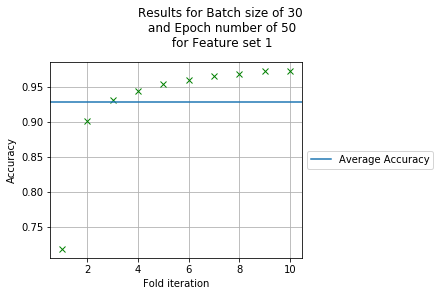

In [49]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [50]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 0.4215 - accuracy: 0.96 - ETA: 1s - loss: 0.9446 - accuracy: 0.95 - ETA: 1s - loss: 0.7409 - accuracy: 0.96 - ETA: 1s - loss: 0.6777 - accuracy: 0.96 - ETA: 1s - loss: 0.5763 - accuracy: 0.96 - ETA: 1s - loss: 0.5189 - accuracy: 0.96 - ETA: 1s - loss: 0.5704 - accuracy: 0.96 - ETA: 1s - loss: 0.8516 - accuracy: 0.96 - ETA: 1s - loss: 0.8452 - accuracy: 0.96 - ETA: 1s - loss: 0.7812 - accuracy: 0.96 - ETA: 1s - loss: 0.7780 - accuracy: 0.96 - ETA: 0s - loss: 0.7204 - accuracy: 0.96 - ETA: 0s - loss: 0.6746 - accuracy: 0.96 - ETA: 0s - loss: 0.6502 - accuracy: 0.96 - ETA: 0s - loss: 0.6120 - accuracy: 0.96 - ETA: 0s - loss: 0.6359 - accuracy: 0.96 - ETA: 0s - loss: 0.6131 - accuracy: 0.96 - ETA: 0s - loss: 0.5996 - accuracy: 0.96 - ETA: 0s - loss: 0.5920 - accuracy: 0.96 - ETA: 0s - loss: 0.5934 - accuracy: 0.96 - ETA: 0s - loss: 0.6051 - accuracy: 0.96 - ETA: 0s - loss:

## Model from Github

In [76]:
# Model from GitHub

#adding layers and forming the model

#forming model
model_5=Sequential()

model_5.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_5.add(MaxPooling2D(padding="same"))

model_5.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_5.add(MaxPooling2D(padding="same"))
model_5.add(Dropout(0.3))

model_5.add(Flatten())

model_5.add(Dense(256,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(512,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(10,activation="softmax"))

#compiling
Model_5=model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [77]:
Accuracy_array_5=[]
accuracy_total_5=0
end_array_5=[]

Epoch_array_accuracy_5=[]
Loss_array_5=[]
Fold_accuracy_5=[]

Val_accuracy_array_5=[]
Val_Loss_array_5=[]

Avg_Accuracy_5=[]
Time_5=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_5=Model_run_nn_es_NO_EARLY_STOPPING(Model_5,model_5,X_folds_10,Y_folds_10,Accuracy_array_5,
                     accuracy_total_5,end_array_5,Epoch_array_accuracy_5,Loss_array_5,
                     Fold_accuracy_5,Val_accuracy_array_5,Val_Loss_array_5, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_5=Model_5[0]
Time_5=Model_5[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.11319760233163834
Time to train Fold 1 : 150.1612 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.11283529549837112
Time to train Fold 2 : 175.811 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.11121301352977753
Time to train Fold 3 : 176.786 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.11237406730651855
Time to train Fold 4 : 165.4919 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.11209594458341599
Time to train Fold 5 : 171.1753 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 24, 4, 1) (823, 10)
Accuracy of Fold 6 is 0.11760778725147247
Time to train Fold 6 : 178.827

In [78]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.02354522861828357, 0.013121138284988499, 0.1145475372279496, 0.1145475372279496
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.01853396348809193, 0.010203040506070809, 0.10101010101010101, 0.10101010101010101
5, 0.020625020625020623, 0.011414274234787055, 0.10683760683760683, 0.10683760683760683
6, 0.012611602729059193, 0.006826815329035078, 0.08262454434993925, 0.08262454434993925
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.018352329796060964, 0.010098279507881584, 0.10049019607843138, 0.10049019607843138
10, 0.02222222222222222, 0.012345679012345678, 0.1111111111111111, 0.1111111111111111


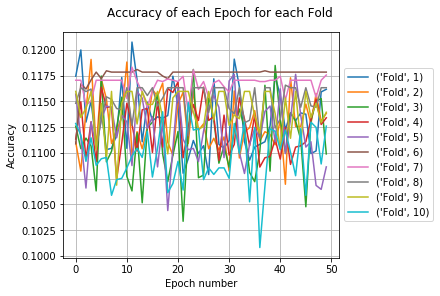

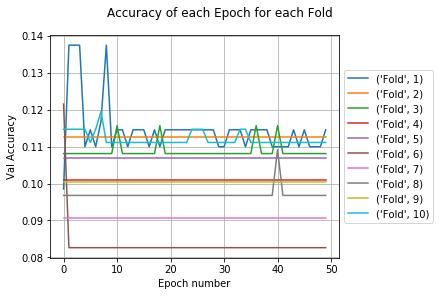

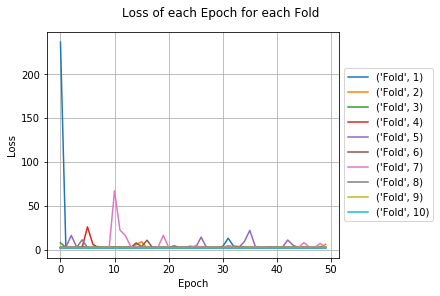

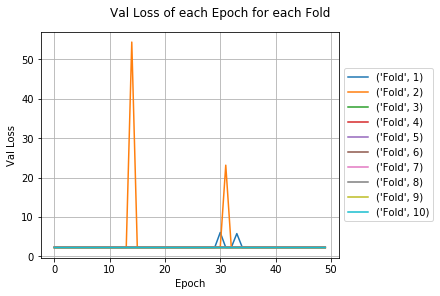

In [79]:
Graph_Epochs_model_5=Graph_func(Epoch_number,Epoch_array_accuracy_5,Val_accuracy_array_5,Loss_array_5,Val_Loss_array_5) 

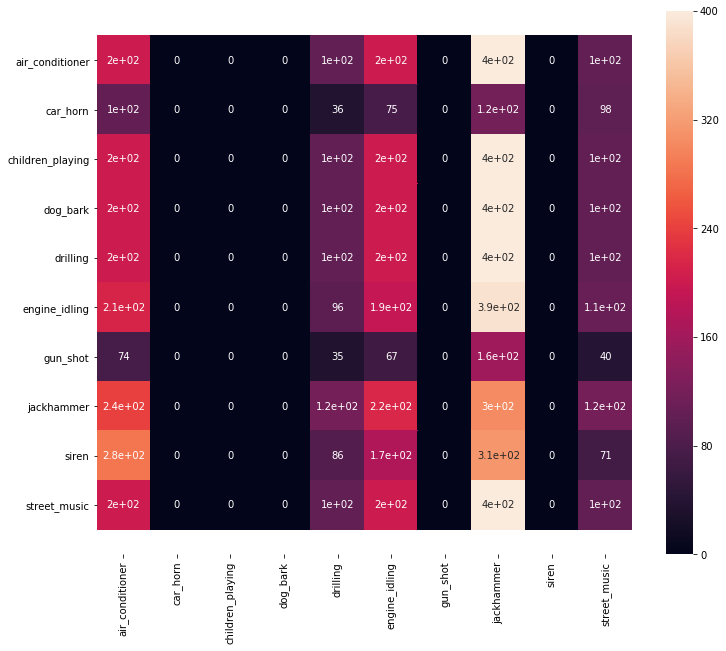

In [80]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [81]:
Table_model_5=table_maker(Fold_accuracy_5,end_array_5,Avg_Accuracy_5,Time_5)

  Fold  Accuracy  Time Taken
0    1  0.113198    150.1612
1    2  0.112835    175.8110
2    3  0.111213    176.7860
3    4  0.112374    165.4919
4    5  0.112096    171.1753
5    6  0.117608    178.8278
6    7  0.116666    172.8784
7    8  0.115132    182.9801
8    9  0.114048    190.2409
9   10  0.109685    186.6477

    Average Accuracy  Total Time
0          0.113485   1751.0003


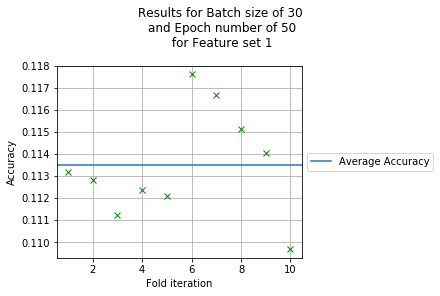

In [82]:
Graph_Avg_model_5=Graph_Avg_maker(Fold_accuracy_5,Avg_Accuracy_5)

### Github model with no cross validation

In [83]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_5_history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_5_no_cross=model_5.evaluate(X_test, y_test)
accuracy_model_5_no_cross = score_model_5_no_cross[1]
print(f"\nAccuracy of model 5 with no cross validation: {round(accuracy_model_5_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 2s - loss: 2.2278 - accuracy: 0.06 - ETA: 2s - loss: 2.2830 - accuracy: 0.07 - ETA: 2s - loss: 2.2834 - accuracy: 0.08 - ETA: 2s - loss: 2.2793 - accuracy: 0.09 - ETA: 2s - loss: 2.2672 - accuracy: 0.08 - ETA: 2s - loss: 2.2672 - accuracy: 0.08 - ETA: 2s - loss: 2.2653 - accuracy: 0.09 - ETA: 2s - loss: 2.2673 - accuracy: 0.09 - ETA: 2s - loss: 2.2665 - accuracy: 0.09 - ETA: 2s - loss: 2.2626 - accuracy: 0.09 - ETA: 2s - loss: 2.2638 - accuracy: 0.10 - ETA: 2s - loss: 2.2632 - accuracy: 0.10 - ETA: 2s - loss: 2.2602 - accuracy: 0.09 - ETA: 1s - loss: 2.2588 - accuracy: 0.09 - ETA: 1s - loss: 2.2595 - accuracy: 0.10 - ETA: 1s - loss: 2.2599 - accuracy: 0.10 - ETA: 1s - loss: 2.2609 - accuracy: 0.10 - ETA: 1s - loss: 2.2596 - accuracy: 0.10 - ETA: 1s - loss: 2.2602 - accuracy: 0.10 - ETA: 1s - loss: 2.2613 - accuracy: 0.10 - ETA: 1s - loss: 2.2621 - accuracy: 0.10 - ETA: 1s - loss:

### Model comparisson

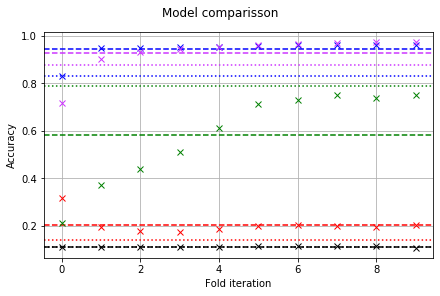

In [86]:
%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Fold_accuracy_4,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Fold_accuracy_5,"kx",label="Model 5")
ax1.axhline(y=Avg_Accuracy_5,label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.66


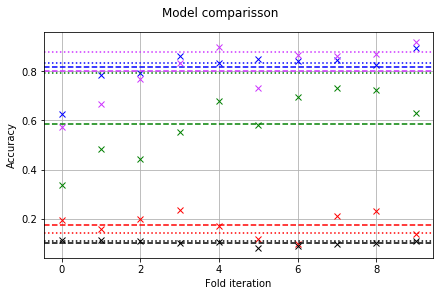

In [85]:
Val_accuracy_array_fix = [Val_accuracy_array[i][-1] for i in range(10)]
Val_accuracy_array_2_fix = [Val_accuracy_array_2[i][-1] for i in range(10)]
Val_accuracy_array_3_fix = [Val_accuracy_array_3[i][-1] for i in range(10)]
Val_accuracy_array_4_fix = [Val_accuracy_array_4[i][-1] for i in range(10)]
Val_accuracy_array_5_fix = [Val_accuracy_array_5[i][-1] for i in range(10)]

 

%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Val_accuracy_array_fix,"rx",label="Model 1")
ax1.axhline(y=np.average(Val_accuracy_array_fix),label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Val_accuracy_array_2_fix,"bx",label="Model 2")
ax1.axhline(y=np.average(Val_accuracy_array_2_fix),label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Val_accuracy_array_3_fix,"gx",label="Model 3")
ax1.axhline(y=np.average(Val_accuracy_array_3_fix),label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Val_accuracy_array_4_fix,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=np.average(Val_accuracy_array_4_fix),label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Val_accuracy_array_5_fix,"kx",label="Model 5")
ax1.axhline(y=np.average(Val_accuracy_array_5_fix),label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))